# Kaggle Baseline Model

In this notebool we will the kaggle baseline model, with explanations and some improvement

### Import librairies

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import  tqdm

import gc # for cleaning

In [2]:
# some configurations
BASE_FOLDER = '../../data/godaddy-microbusiness-density-forecasting'


### Useful functions

In [3]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))

    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)

    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]

    return 100 * np.mean(smap)

def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))

    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)

    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]

    return 100 * smap

### Load data

In [17]:
census = pd.read_csv(f'{BASE_FOLDER}/census_interpolated.csv')
census['first_day_of_month'] = pd.to_datetime(census['first_day_of_month'])
census = census.drop(columns = ['year'])
census.head()

,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc,cfips,first_day_of_month
0,76.600000,14.500000,2.100000,1.300000,55317.000000,1001,2019-01-01
1,76.791667,14.616667,2.091667,1.283333,55606.083333,1001,2019-02-01
2,76.983333,14.733333,2.083333,1.266667,55895.166667,1001,2019-03-01
3,77.175000,14.850000,2.075000,1.250000,56184.250000,1001,2019-04-01
4,77.366667,14.966667,2.066667,1.233333,56473.333333,1001,2019-05-01


In [18]:
train = pd.read_csv(BASE_FOLDER + '/train.csv')
test = pd.read_csv(BASE_FOLDER + '/test.csv')
sub = pd.read_csv(BASE_FOLDER + '/sample_submission.csv')

print(f'train = {train.shape}')
print(f'test = {test.shape}')
print(f'sub = {sub.shape}')

train = (122265, 7)
test = (25080, 3)
sub = (25080, 2)


In [23]:
# merge train and test
train['is_test'] = 0
test['is_test'] = 1

raw = pd.concat((train, test)).sort_values(['cfips', 'row_id']).reset_index(drop = True)

# some formatting
raw['first_day_of_month'] = pd.to_datetime(raw['first_day_of_month'])
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
raw['year'] = raw['first_day_of_month'].dt.year
raw['month'] = raw['first_day_of_month'].dt.month
raw['dcount'] = raw.groupby(['cfips'])['row_id'].cumcount() # timestep for every cfipis
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]

### Remove outliers and some anomalies

<AxesSubplot:xlabel='dcount'>

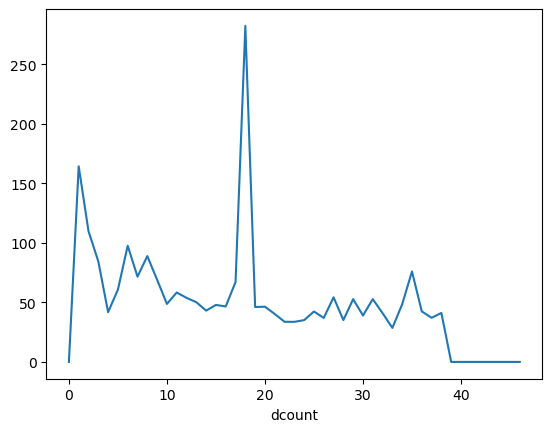

In [24]:
# check if there are huge variations between two consecutive months

lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill() # previous month
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1 # relative difference with previous month
raw.loc[(raw[f'mbd_lag_{lag}'] == 0), 'dif'] = 0 # if previous month is 0, then the relative difference is 0
raw.loc[ (raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}'] == 0), 'dif' ] = 1 # if previous month is 0 and current month is not 0, then the relative difference is 1
raw['dif'] = raw['dif'].abs() # want only to see the absolute difference

raw.groupby('dcount')['dif'].sum().plot() # plot the sum of the absolute difference for each timestep

### We can clearly see that there are some anomalies, specially at time step 18

In [25]:
# Check for outliers and normalize them

outliers = []

cnt = 0
for o in tqdm(raw.cfips.unique()): # for each county

    indices = (raw['cfips'] == o) # indices of the current county

    tmp = raw.loc[indices].copy().reset_index(drop = True) # current county
    var = tmp.microbusiness_density.values.copy() # microbusiness density of the current county

    for i in range(37, 2, -1): # for each timestep except the last one known (38)

        thr = 0.20 * np.mean(var[:i]) # 20% of the mean of the previous values
        difa = abs(var[i] - var[i-1]) # absolute difference with the previous value
        if (difa >= thr): # if the variation is too big
            var[:i] *= (var[i]/var[i-1]) # normalize the previous values
            outliers.append(o) # add the county to the outliers list
            cnt += 1 # increment the number of outliers
    var[0] = var[1] * 0.99 # why ?
    raw.loc[indices, 'microbusiness_density'] = var # update the microbusiness density of the current county

outliers = np.unique(outliers)
len(outliers), cnt

  0%|          | 0/3135 [00:00<?, ?it/s]

C:\Users\avomo\AppData\Local\Temp\ipykernel_17172\4196573292.py:18: RuntimeWarning: invalid value encountered in double_scalars
  var[:i] *= (var[i]/var[i-1]) # normalize the previous values
C:\Users\avomo\AppData\Local\Temp\ipykernel_17172\4196573292.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  var[:i] *= (var[i]/var[i-1]) # normalize the previous values
C:\Users\avomo\AppData\Local\Temp\ipykernel_17172\4196573292.py:18: RuntimeWarning: invalid value encountered in multiply
  var[:i] *= (var[i]/var[i-1]) # normalize the previous values
C:\Users\avomo\AppData\Local\Temp\ipykernel_17172\4196573292.py:16: RuntimeWarning: invalid value encountered in double_scalars
  difa = abs(var[i] - var[i-1]) # absolute difference with the previous value


(481, 732)

<AxesSubplot:xlabel='dcount'>

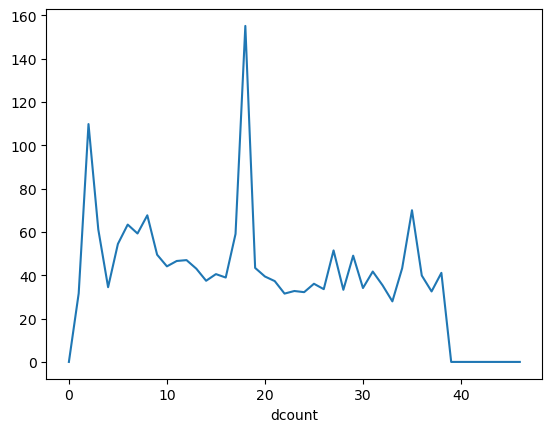

In [26]:
# display againt the sum of the absolute difference for each timestep

lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
raw['dif'] = raw['dif'].abs()

raw.groupby('dcount')['dif'].sum().plot()

<AxesSubplot:xlabel='dcount'>

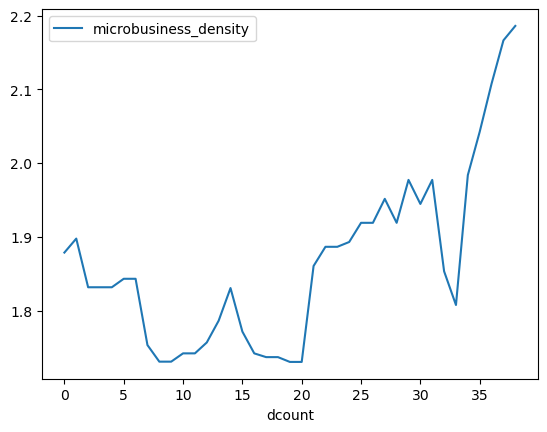

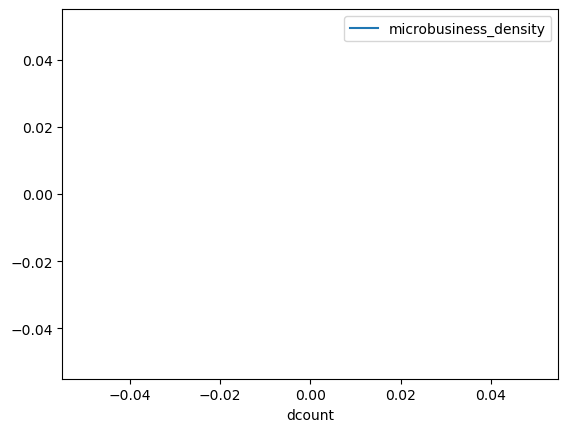

In [27]:
raw.loc[raw.cfips == 1089].plot(x='dcount', y='microbusiness_density')
raw.loc[raw.cfips == 21277].plot(x='dcount', y='microbusiness_density')